<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BGD_12%5D_Made_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12-7. Project: 멋진 챗봇 만들기

In [ ]:
# LMS와 버젼 맞추기
# Word2Vec을 사용하기위해 LMS와 다른 버젼인 3.6.0으로 프로젝트를 수행하기로 함

# !pip install gensim==4.1.2

In [ ]:
# mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim
import re
import urllib.request
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook 
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.6
1.3.5
2.9.2
3.7
3.6.0


# Step 1. 데이터 다운로드

- 준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

[songys/Chatbot_data](https://github.com/songys/Chatbot_data)

In [ ]:
# 데이터 불러오기

urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
# 데이터 개수 확인
print(train_data.shape)

(11823, 3)


In [ ]:
# 데이터에 알파벳이 포함되어있는지 확인
train_data[train_data['Q'].str.contains('A')]

,Q,A,label
8887,AB형 남자랑 썸 타면,최대한 이해해보세요.,2
8888,AB형 여자랑 썸 타면,하고 싶은 걸 표현할 수 있게 해주세요.,2
8889,A형 남자랑 썸을 타게 됨,사소한 걸 기억해보세요.,2
8890,A형 여자랑 썸을 타게 됨,세심하게 챙겨주세요.,2


In [ ]:
# 데이터에 알파벳이 포함되어있는지 확인
train_data[train_data['A'].str.contains('A')]

,Q,A,label
4742,컴터 고장났나봐,AS센터에 맡겨보세요.,0
4744,컴터가 맛이 갔어,AS센터에 맡겨보세요.,0
4745,컴터가 안돼,AS센터에 맡겨보세요.,0
8359,컴터가 맛이 갔어,AS센터에 맡겨보세요.,1


In [ ]:
# 결측값 확인
train_data.isnull().sum()

# 결측치는 존재하지 않는다.

Q        0
A        0
label    0
dtype: int64

In [ ]:
# 데이터 중복값 확인
print(train_data.duplicated(subset='Q', keep='first').sum())
print(train_data.duplicated(subset='A', keep='first').sum())
# keep = 'first'는 중복이 있으면 처음과 마지막 값 중 처음값을 남긴다.

161
4044


중복값을 사전에 제거 후 데이터를 분리하여 담기로 결정하였다. 토큰화 이후 진행보다는 더 편리하다고 생각하였다.

In [ ]:
# 중복 문장 제거 후 질문과 답변 따로 저장하기
columns = ['Q', 'A']
questions = []
answers = []

for col in columns:
  train_data.drop_duplicates(subset=[col], inplace=True)

for Q, A in zip(train_data['Q'], train_data['A']):
  questions.append(str(Q)), answers.append(str(A))
  
# 중복 제거 확인

print(train_data.duplicated(subset='Q', keep='first').sum())
print(train_data.duplicated(subset='A', keep='first').sum())
print(train_data.shape)
print(type(questions), type(answers))

0
0
(7731, 3)
<class 'list'> <class 'list'>


In [ ]:
print(questions[0], answers[0])

12시 땡! 하루가 또 가네요.


기존 데이터에서 약 4000개가 줄어들었기 때문에 데이터 증강 작업이 필요할 것으로 예상된다.

# Step 2. 데이터 정제
- 아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요

1. 영문자의 경우, 모두 소문자로 변환합니다.

2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [ ]:
# 데이터 전처리 함수 구현

def preprocess_sentence(sentence):
    sentence = sentence.lower() # 영문자 소문자
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-z?.!,]+", " ", sentence)  # ^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-z?.!,가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip()  # 양 옆 공백 제거
    
    return sentence

In [ ]:
# 전처리 테스트 시행
sen = 'WOW! 정말 재밌는 영화네요!!:'
print(preprocess_sentence(sen))

wow! 정말 재밌는 영화네요!!


# Step 3. 데이터 토큰화

- 토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
 
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.

3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.

4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.

5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.


In [ ]:
# 적절한 문장의 길이를 선택하기 위해 전처리 적용

questions = [preprocess_sentence(Q) for Q in train_data['Q']]
answers = [preprocess_sentence(A) for A in train_data['A']]

In [ ]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', 'ppl 심하네', 'sd카드 망가졌어']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .']


In [ ]:
# 한글 데이터 Mecab 적용하기
mecab = Mecab()

Q_len = []
for sentence in questions:
  Q_len.append(mecab.morphs(sentence))

A_len = []
for sentence in answers:
  A_len.append(mecab.morphs(sentence))

In [ ]:
print(type(Q_len), type(A_len), len(Q_len), len(A_len))

<class 'list'> <class 'list'> 7731 7731


문장의 최단 길이: 1
문장의 최장 길이: 32
문장의 평균 길이: 7


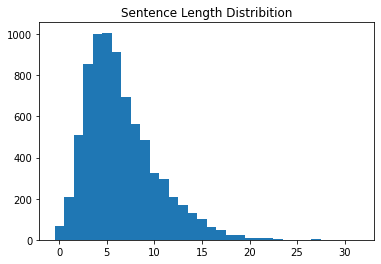

In [ ]:
# Q_len 길이 분포 확인하기

min_len = 999
max_len = 0
sum_len = 0

for sen in Q_len:
  length = len(sen)
  if min_len > length: min_len = length
  if max_len < length: max_len = length
  sum_len += length

print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len // len(Q_len))

sentence_length = np.zeros((max_len), dtype = np.int64)

for sen in Q_len:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width = 1.0)
plt.title('Sentence Length Distribition')
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 40
문장의 평균 길이: 8


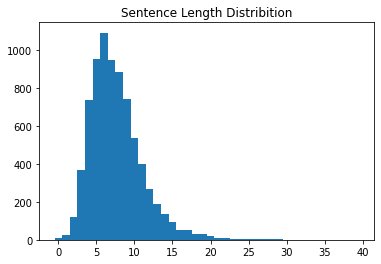

In [ ]:
# A_len 길이 분포 확인하기

min_len = 999
max_len = 0
sum_len = 0

for sen in A_len:
  length = len(sen)
  if min_len > length: min_len = length
  if max_len < length: max_len = length
  sum_len += length

print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len // len(A_len))

sentence_length = np.zeros((max_len), dtype = np.int64)

for sen in A_len:
  sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width = 1.0)
plt.title('Sentence Length Distribition')
plt.show()

In [ ]:
# 샘플 길이에따른 데이터 분포 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
# Q_len의 길이 별 분포 확인하기
Q_token_len = [7, 32, 10, 12, 15, 17, 20]

for num in Q_token_len:
  below_threshold_len(num, Q_len)

전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.5904798861725521
전체 샘플 중 길이가 32 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8159358427111628
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.8960031043849437
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9614538869486483
전체 샘플 중 길이가 17 이하인 샘플의 비율: 0.9826671840641573
전체 샘플 중 길이가 20 이하인 샘플의 비율: 0.9949553744664338


In [ ]:
# A_len의 길이 별 분포 확인하기
A_token_len = [8, 40, 10, 12, 15, 17, 20]

for num in A_token_len:
  below_threshold_len(num, A_len)

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.549217436295434
전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.7591514681153796
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.8799637821756564
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9565386107877377
전체 샘플 중 길이가 17 이하인 샘플의 비율: 0.9752942698227913
전체 샘플 중 길이가 20 이하인 샘플의 비율: 0.9901694476781787


Q_len, A_len의 길이 분포로 보아 토큰 길이는 15로 결정하기로 하였다.

In [ ]:
# build_corpus 함수 구현

Q_len = []
A_len = []
que_corpus = []
ans_corpus = []

def build_corpus(questions, answers):
  questions = [preprocess_sentence(Q) for Q in train_data['Q']] # 전처리 시행
  answers = [preprocess_sentence(A) for A in train_data['A']]

  for sen in questions:
    Q_len.append(mecab.morphs(sen)) # mecab을 사용하여 전처리 수행

  for sen in answers:
    A_len.append(mecab.morphs(sen))

  for Q, A in zip(Q_len, A_len):
    if (len(Q) <= 15) and (len(A) <= 15):
      que_corpus.append(Q)
      ans_corpus.append(A)

In [ ]:
build_corpus(questions, answers)

In [ ]:
print(below_threshold_len(15, que_corpus), below_threshold_len(15, ans_corpus))
print(len(que_corpus), len(ans_corpus))

전체 샘플 중 길이가 15 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 15 이하인 샘플의 비율: 1.0
None None
7122 7122


In [ ]:
# 토큰화 적용 결과 보가
print(que_corpus[:5])
print(ans_corpus[:5])

[['12', '시', '땡', '!'], ['1', '지망', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'], ['ppl', '심하', '네'], ['sd', '카드', '망가졌', '어']]
[['하루', '가', '또', '가', '네요', '.'], ['위로', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋', '죠', '.'], ['눈살', '이', '찌푸려', '지', '죠', '.'], ['다시', '새로', '사', '는', '게', '마음', '편해요', '.']]


각 corpus가 길이가 15로 잘 제한되어 담긴것을 확인하였다.

# Step 4. Augmentation
- 우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

- 아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

[Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [ ]:
# 경로 지정
%cd /content/drive/MyDrive/Aiffel/GD_project/GD12

# 압축해제
!unzip /content/drive/MyDrive/Aiffel/GD_project/GD12/ko.zip

/content/drive/MyDrive/Aiffel/GD_project/GD12
Archive:  /content/drive/MyDrive/Aiffel/GD_project/GD12/ko.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


gensim을 4.1.2에서 colab의 기본 버젼인 3.6.0으로 다시 낮추었다. 그 이유는 4.1.2 버젼에서는 작동이 되지 않았기 때문이다.

In [ ]:
# gensim version down

!pip install gensim==3.6.0

In [ ]:
# ko.bin 파일 불러오기
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_path = '/content/drive/MyDrive/Aiffel/GD_project/GD12/ko.bin'

word2vec = Word2Vec.load(w2v_path)

In [ ]:
word2vec.similar_by_word("기쁨")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('즐거움', 0.7912124395370483),
 ('슬픔', 0.7767106294631958),
 ('아름다움', 0.6815950870513916),
 ('웃음', 0.681169331073761),
 ('괴로움', 0.6798388957977295),
 ('행운', 0.6609852313995361),
 ('인생', 0.657120406627655),
 ('젊음', 0.6522527933120728),
 ('영광', 0.6512227058410645),
 ('행복', 0.6493781805038452)]

In [ ]:
# Lexical Substitution 구현

import random

def lexical_sub(sentence, word2vec):
  res = ''
  toks = sentence

  try:
    _from = random.choice(toks)
    _to = word2vec.most_similar(_from)[0][0]

  except: # 단어장에 없는 단어
    return None
  
  for tok in toks:
    if tok is _from: res += _to + ' '
    else: res += tok + ' '
    
  return res

In [ ]:
print("원본:", que_corpus[0])
print("결과:", lexical_sub(que_corpus[0], word2vec))

원본: ['12', '시', '땡', '!']
결과: 12 시 끗 ! 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()


[Data Augmentation 코드 참고](https://github.com/SIMYJ/NLP_Projects/blob/master/%5BGD_NLP_12%5Dtransformer_chatbot.ipynb)

In [ ]:
from tqdm import tqdm_notebook

new_que_corpus = []
new_ans_corpus = []

# Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록
for idx in tqdm_notebook(range(len(que_corpus))):
    que_augmented = lexical_sub(que_corpus[idx], word2vec)
    ans = ans_corpus[idx]
    if que_augmented is not None:
        new_que_corpus.append(que_augmented.split())
        new_ans_corpus.append(ans)
    else:
        continue
    
for idx in tqdm_notebook(range(len(ans_corpus))):
    que = que_corpus[idx]
    ans_augmented = lexical_sub(ans_corpus[idx], word2vec)
    
    if ans_augmented is not None:
        new_que_corpus.append(que)
        new_ans_corpus.append(ans_augmented.split())
    else:
        continue

que_corpus_arg = que_corpus + new_que_corpus
ans_corpus_arg = ans_corpus + new_ans_corpus

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/7122 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/7122 [00:00<?, ?it/s]

In [ ]:
# 결과 확인
print(que_corpus_arg[:5])
print(ans_corpus_arg[:5])
print(len(que_corpus_arg), len(ans_corpus_arg))

[['12', '시', '땡', '!'], ['1', '지망', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'], ['ppl', '심하', '네'], ['sd', '카드', '망가졌', '어']]
[['하루', '가', '또', '가', '네요', '.'], ['위로', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋', '죠', '.'], ['눈살', '이', '찌푸려', '지', '죠', '.'], ['다시', '새로', '사', '는', '게', '마음', '편해요', '.']]
19487 19487


데이터를 증강하여 약 3배로 만들었다.

# Step 5. 데이터 벡터화
- 타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!



1.  소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!


In [ ]:
# 토큰 추가하기

tgt_corpus = []

for cor in ans_corpus_arg:
  tgt_corpus.append(["<start>"] + cor + ["<end>"])

print(tgt_corpus[:3])
ans_corpus_arg = tgt_corpus

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'], ['<start>', '위로', '해', '드립니다', '.', '<end>'], ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>']]


[단어 사전 구축 참고 코드](https://github.com/SIMYJ/NLP_Projects/blob/master/%5BGD_NLP_12%5Dtransformer_chatbot.ipynb)

In [ ]:
# 단어 사전 구축하기

from collections import Counter

voc_data = que_corpus_arg + ans_corpus_arg

words = np.concatenate(voc_data).tolist()
counter = Counter(words)
counter = counter.most_common(30000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

que_train = vectorize(que_corpus_arg, word_to_index)
ans_train = vectorize(ans_corpus_arg, word_to_index)

print(len(que_train))
print(len(ans_train))

19487
19487


In [ ]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(que_train, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(ans_train, padding='post')

enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.01) # test set은 1%로 지정

name_set = [enc_train, enc_val, dec_train, dec_val]
for name in name_set:
  print('Data Size : ',len(name))


Data Size :  19292
Data Size :  195
Data Size :  19292
Data Size :  195


# Step 6. 훈련하기

- 앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

1. 트랜스포머 구현하기

아래 웹페이지를 참고하여 구현한다.

[위키독스: 트랜스포머](https://wikidocs.net/31379)

[Trax: Transformer](https://github.com/google/trax/blob/master/trax/models/transformer.py)

[Tensorflow: Transformer](https://www.tensorflow.org/text/tutorials/transformer)

In [ ]:
# Positional Encoding 구현

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

tf.cast() : 배열의 dtype을 변경시켜준다
tf.math.equal() : 
[텐서플로우를 이용한 논리연산](https://chan-lab.tistory.com/m/9)

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FcRzJTh%2FbtqwMdHnKKz%2F64aVKDH4W04DsJm2ybOSr1%2Fimg.png)
<center>tf.math.equal 예시/center>



In [ ]:
# Mask 생성하기

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [ ]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [ ]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [ ]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [ ]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
# 트랜스포머 전체 모델 조립

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 사용하게될 하이퍼 파라미터

n_layers = 1
d_model = 368
n_heads = 8
d_ff = 1024
dropout = 0.2

In [ ]:
# 트랜스포머 하이퍼 파라미터 지정
VOCAB_SIZE = 20000

transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads = 8,
    d_ff = d_ff,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

In [ ]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [ ]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [ ]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def get_decoded_sentence(encoded_sentence, idx2word):
    return ' '.join(idx2word[index] if index in idx2word else '<UNK>' for index in encoded_sentence[1:]) 

def get_decoded_sentences(encoded_sentences, idx2word):
    return [get_decoded_sentence(encoded_sentence, idx2word) for encoded_sentence in encoded_sentences]

In [ ]:
# evaluate 및 translate 함수 구현

pieces = None
sentence = None

def evaluate(model):
    
#    sentence = preprocess_sentence(sentence)
#    pieces = mecab.morphs(sentence)
    
    tokens = []
    for sen in pieces:
        sen= get_encoded_sentence(sen, word_to_index)
        tokens.append(sen)
    
    _input = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                        value=word_to_index["<pad>"],
                                                        padding='pre',
                                                        maxlen=20)
    
    ids = []
    output = tf.expand_dims([word_to_index["<start>"]], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(model)

    return result

In [ ]:
def evaluate(sentence, model):
    # sentence 전처리(enc_train과 같은 모양으로)
    sentence = preprocess_sentence(sentence)
    pieces = sentence
    tokens = get_encoded_sentence(pieces, word_to_index)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    
    output = tf.expand_dims([word_to_index["<start>"]], 0) 
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        # 예측 단어가 종료 토큰일 경우
        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        ##word_to_index
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    return result

In [ ]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

In [ ]:
# 챗봇 성능 테스트
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]
 
for example in examples:
  translate(example, transformer)
  print('\n')

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 확신 하 고 있 나 봐요 .


Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 자주 만나 보 세요 .


Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 도 이해 해 주 세요 .


Input: 집에 있는다는 소리야.
Predicted translation: 만 에 즐거운 시간 이 될 거 예요 .




# Step 7. 성능 측정하기

- 챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def eval_bleu(src_corpus, tgt_corpus, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)

    for idx in tqdm_notebook(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]
        
        src = []
        tgt = []
        
        for word in src_tokens:
            if word !=0 and word !=1 and word !=3 and word !=4:
                src.append(word)
        
        for word in tgt_tokens:
            if word != 0 and word != 3 and word !=4:
                tgt.append(word)

        src_sentence = get_decoded_sentence(src, index_to_word)
        tgt_sentence = get_decoded_sentence(tgt, index_to_word)
        
        
        reference = preprocess_sentence(tgt_sentence)
        candidate = translate(src_sentence, transformer)

        score = sentence_bleu([reference], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            print("Source Sentence: ", src_sentence)
            print("Model Prediction: ", candidate)
            print("Real: ", reference)
            print("Score: %lf\n" % score)

    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [ ]:
eval_bleu(enc_val[:25], dec_val[:25], verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/25 [00:00<?, ?it/s]

Input: 론가 훌쩍 떠나 고 싶 으며
Predicted translation: 은 마음 이 오 지 않 은데 관계 가 있 어요 .
Source Sentence:  론가 훌쩍 떠나 고 싶 으며
Model Prediction:  은 마음 이 오 지 않 은데 관계 가 있 어요 .
Real:  김 에 떠나 보 세요 .
Score: 0.042698

Input: 친구 가 되 어 줘 .
Predicted translation: 의 잘못 이 에요 .
Source Sentence:  친구 가 되 어 줘 .
Model Prediction:  의 잘못 이 에요 .
Real:  많 은 이야기 를 나눠 봐요 .
Score: 0.073958

Input: 여행 가 면 잘 싸워 ?
Predicted translation: 하 고 있 어요 .
Source Sentence:  여행 가 면 잘 싸워 ?
Model Prediction:  하 고 있 어요 .
Real:  초면 싸우 기 도 하 는 거 같 아요 .
Score: 0.043032

Input: 참 잔인 하 네 .
Predicted translation: 적 인 감정 이 에요 .
Source Sentence:  참 잔인 하 네 .
Model Prediction:  적 인 감정 이 에요 .
Real:  사랑 했 던 사람 이 가장 아프 게 시키 죠 .
Score: 0.038693

Input: 하 는 건지 나 도 모르 겠 어
Predicted translation: 쏠 여부 가 큰 걸림돌 이 되 지 않 을 거 예요 .
Source Sentence:  하 는 건지 나 도 모르 겠 어
Model Prediction:  쏠 여부 가 큰 걸림돌 이 되 지 않 을 거 예요 .
Real:  어도 살 수 있 는지 생각 해 보 세요 .
Score: 0.050131

Input: 어떻게 하 는지 까먹 었 어 .
Predicted translation: 도 좋 은 선택 하 지 않 길 바랍니다 .
Source Sentence:  어떻게 하 는지 까먹 었 어

# 회고

1. 이번 프로젝트에서 어려웠던 점
 
(1) 단어 사전 구축 과정이 익숙하지않아서 코드를 참고하여야합니다.
 - 구글링을 통하여 다음 코드를 참고하여 단어 사전 구축을 진행하였습니다.
 - [참고코드](https://github.com/SIMYJ/NLP_Projects/blob/master/%5BGD_NLP_12%5Dtransformer_chatbot.ipynb).

(2) 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 자연어처리 평가지표 : Bleu score
- 저번에 사용한 Rouge socre말고 이번에는 Bleu score를 사용해보았습니다.
- 기계 번역에서 모델이 번역한 문장과 실제 번역문을 단어 단위로 나눠 어느정도의 유사성을 가지고 있는지 알 수 있는 방식입니다.






